[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Azimi/box.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/deJong_Azimi/box.ipynb)    
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Azimi/box.ipynb)

TODO #1417

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [1]:
from typing import Optional

import numpy as np
from scipy.special import gamma
from matplotlib import pyplot

from open_atmos_jupyter_utils import show_plot

from PySDM_examples.deJong_Azimi import run_box, cloudy_data_0d

from PySDM import Formulae
from PySDM.physics import si, in_unit
from PySDM.dynamics.collisions.collision_kernels import SimpleGeometric, Golovin
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.initialisation.spectra import Gamma

In [2]:
class Settings0D:  # pylint: disable=too-many-instance-attributes,too-few-public-methods,missing-class-docstring
    def __init__(
        self,
        kernel: object,
        steps: list,
        radius_bins_edges: Optional[np.ndarray] = None,
    ):
        self.kernel = kernel
        self.n_sd = 2**12
        self.n_part = 100 / si.cm**3
        self.dv = 1 * si.m**3
        self.rho = 1000 * si.kg / si.m**3
        self.rhod = 1 * si.kg / si.m**3
        self.dt = 1 * si.s
        self.adaptive = True
        self.steps = steps
        self.coal_eff = ConstEc(Ec=1.0)
        self.spectrum = Gamma(
            norm_factor=self.n_part * self.dv, k=1.0, theta=1e5 * si.um**3
        )
        self.radius_bins_edges = radius_bins_edges if radius_bins_edges is not None else np.logspace(
            np.log10(8.0 * si.um), np.log10(5000 * si.um), num=64, endpoint=True
        )
        self.formulae = Formulae(terminal_velocity="PowerSeries")

In [3]:
def dvdlnr_gamma(m, N, theta, k):
    return N * m**(k-1) * np.exp(-m / theta) / theta**k / gamma(k)

## Golovin Kernel

In [24]:
settings_a = Settings0D(
    kernel = Golovin(b=5e3 * si.s),
    steps = [0, 60, 120]
)
res_a = run_box(settings_a)

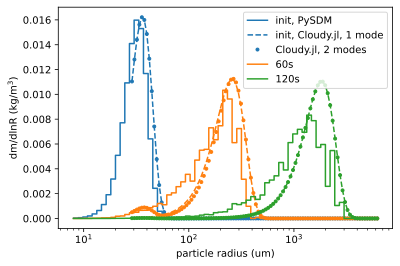

HTML(value="<a href='./box1.pdf' target='_blank'>./box1.pdf</a><br>")

In [25]:
fig, ax = pyplot.subplots(ncols=1, sharey=True, figsize=(6,4), dpi=200)

m_plt_ug = np.logspace(-1.0, 6.0, 100)

r1_plt = settings_a.formulae.trivia.radius(volume=m_plt_ug * si.ug / settings_a.rho)

for (j, step) in enumerate(settings_a.steps):
    line = ax.step(
        in_unit(res_a.radius_bins_left_edges, si.um),
        res_a.dv_dlnr[j] * settings_a.rho,
        label='init, PySDM' if j==0 else (str(step) + 's')
    )
    a1_dmdlnr = dvdlnr_gamma(
        m_plt_ug,
        cloudy_data_0d.MOM_data['Golovin']['aDists'][j][0],
        cloudy_data_0d.MOM_data['Golovin']['aDists'][j][1],
        cloudy_data_0d.MOM_data['Golovin']['aDists'][j][2]
    ) * 3 * m_plt_ug**2 * si.ug / si.cm**3
    ax.plot(
        in_unit(r1_plt, si.um),
        in_unit(a1_dmdlnr, si.kg / si.m**3),
        '--',
        label='init, Cloudy.jl, 1 mode' if j==0 else '_',
        color=line[-1].get_color()
    )

    b1_dmdlnr = dvdlnr_gamma(
        m_plt_ug,
        cloudy_data_0d.MOM_data['Golovin']['bDists1'][j][0],
        cloudy_data_0d.MOM_data['Golovin']['bDists1'][j][1],
        cloudy_data_0d.MOM_data['Golovin']['bDists1'][j][2]
    ) * 3 * m_plt_ug**2 * si.ug / si.cm**3
    b1_dmdlnr += dvdlnr_gamma(
        m_plt_ug,
        cloudy_data_0d.MOM_data['Golovin']['bDists2'][j][0],
        cloudy_data_0d.MOM_data['Golovin']['bDists2'][j][1],
        cloudy_data_0d.MOM_data['Golovin']['bDists2'][j][2]
    ) * 3 * m_plt_ug**2 * si.ug / si.cm**3
    ax.plot(
        in_unit(r1_plt, si.um),
        b1_dmdlnr,
        '.',
        label='Cloudy.jl, 2 modes' if j==0 else '_',
        color=line[-1].get_color()
    )

ax.set_xscale("log")
ax.set_xlabel("particle radius (um)")
ax.set_ylabel("dm/dlnR (kg/m$^3$)")
ax.legend()
show_plot('box1.pdf')

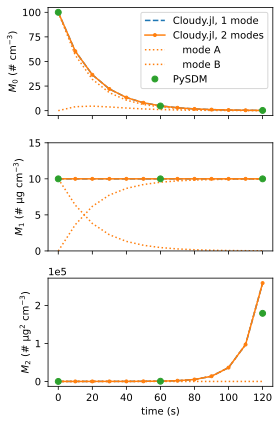

HTML(value="<a href='./box1_moments.pdf' target='_blank'>./box1_moments.pdf</a><br>")

In [6]:
fig, ax = pyplot.subplots(nrows=3, sharex=True, figsize=(4,6), dpi=200, tight_layout=True)
for i in range(3):
    line = ax[i].plot(
        cloudy_data_0d.MOM_data['Golovin']['t'],
        cloudy_data_0d.MOM_data['Golovin']['aMoments'][i],
        '--',
        label='Cloudy.jl, 1 mode'
    )
    line = ax[i].plot(
        cloudy_data_0d.MOM_data['Golovin']['t'],
        cloudy_data_0d.MOM_data['Golovin']['bMoments'][i, 0] 
        + cloudy_data_0d.MOM_data['Golovin']['bMoments'][i, 1],
        '.-',
        label='Cloudy.jl, 2 modes'
    )
    ax[i].plot(
        cloudy_data_0d.MOM_data['Golovin']['t'],
        cloudy_data_0d.MOM_data['Golovin']['bMoments'][i, 0],
        ':',
        linewidth=1.5, label='   mode A', color=line[-1].get_color()
    )
    ax[i].plot(
        cloudy_data_0d.MOM_data['Golovin']['t'],
        cloudy_data_0d.MOM_data['Golovin']['bMoments'][i, 1],
        ':',
        linewidth=1.5, label='   mode B', color=line[-1].get_color()
    )
    ax[i].plot(
        np.asarray(settings_a.steps) * settings_a.dt,
        in_unit(
            res_a.moments[:, i] * settings_a.dv * settings_a.rho**i,
            si.ug**i / si.cm**3
        ),
        marker='o', linestyle='None', label='PySDM'
    )
ax[0].legend()
ax[0].set_ylabel('$M_0$ (# cm$^{-3}$)')
ax[1].set_ylabel('$M_1$ (# µg cm$^{-3}$)')
ax[1].set_ylim([0.0, 15.0])
ax[2].set_ylabel('$M_2$ (# µg$^2$ cm$^{-3}$)')
ax[2].set_xlabel('time (s)')
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,2))

show_plot('box1_moments.pdf')

## Geometric

In [26]:
settings_b = Settings0D(
    kernel = SimpleGeometric(C=1e6 * np.pi),
    steps = [0, 240],
    radius_bins_edges = np.logspace(
        np.log10(8.0 * si.um), np.log10(1000 * si.um), num=64, endpoint=True
    )
)
res_b = run_box(settings_b)

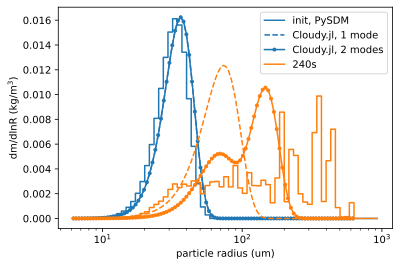

HTML(value="<a href='./box2.pdf' target='_blank'>./box2.pdf</a><br>")

In [27]:
fig, ax = pyplot.subplots(ncols=1, sharey=True, figsize=(6,4), dpi=200)

m_plt_ug = np.logspace(-3.0, 3.0, 100)

r2_plt = settings_b.formulae.trivia.radius(volume=m_plt_ug * si.ug / settings_b.rho)

for (j, step) in enumerate(settings_b.steps):
    line = ax.step(
        in_unit(res_b.radius_bins_left_edges, si.um),
        res_b.dv_dlnr[j] * settings_b.rho,
        label='init, PySDM' if j==0 else (str(step) + 's')
    )
    
    a2_dmdlnr = dvdlnr_gamma(
        m_plt_ug,
        cloudy_data_0d.MOM_data['Geometric']['aDists'][j][0],
        cloudy_data_0d.MOM_data['Geometric']['aDists'][j][1],
        cloudy_data_0d.MOM_data['Geometric']['aDists'][j][2]
    ) * 3 * m_plt_ug**2 * si.ug / si.cm**3
    ax.plot(
        in_unit(r2_plt, si.um),
        in_unit(a2_dmdlnr, si.kg/si.m**3),
        '--',
        label='Cloudy.jl, 1 mode' if j==0 else '_',
        color=line[-1].get_color()
    )

    b2_dmdlnr = dvdlnr_gamma(
        m_plt_ug,
        cloudy_data_0d.MOM_data['Geometric']['bDists1'][j][0],
        cloudy_data_0d.MOM_data['Geometric']['bDists1'][j][1],
        cloudy_data_0d.MOM_data['Geometric']['bDists1'][j][2]
    ) * 3 * m_plt_ug**2 * si.ug / si.cm**3
    b2_dmdlnr += dvdlnr_gamma(
        m_plt_ug,
        cloudy_data_0d.MOM_data['Geometric']['bDists2'][j][0],
        cloudy_data_0d.MOM_data['Geometric']['bDists2'][j][1],
        cloudy_data_0d.MOM_data['Geometric']['bDists2'][j][2]
    ) * 3 * m_plt_ug**2 * si.ug / si.cm**3
    ax.plot(
        in_unit(r2_plt, si.um),
        in_unit(b2_dmdlnr, si.kg/si.m**3),
        '.-',
        label='Cloudy.jl, 2 modes' if j==0 else '_',
        color=line[-1].get_color()
    )

ax.set_xscale("log")
ax.set_xlabel("particle radius (um)")
ax.set_ylabel("dm/dlnR (kg/m$^3$)")
ax.legend()
show_plot('box2.pdf')

In [9]:
settings_c = Settings0D(
    kernel = settings_b.kernel,
    steps = np.linspace(0, 240, 41, dtype=int),
    radius_bins_edges = settings_b.radius_bins_edges,
)
res_c = run_box(settings_c)

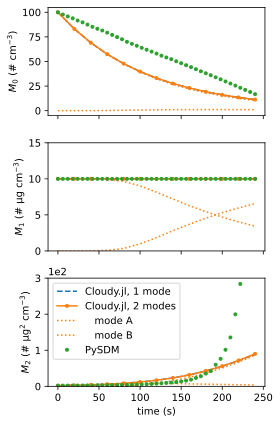

HTML(value="<a href='./box2_moments.pdf' target='_blank'>./box2_moments.pdf</a><br>")

In [15]:
fig, ax = pyplot.subplots(nrows=3, sharex=True, figsize=(4,6), dpi=200, tight_layout=True)
for i in range(3):
    line = ax[i].plot(
        cloudy_data_0d.MOM_data['Geometric']['t'],
        cloudy_data_0d.MOM_data['Geometric']['aMoments'][i],
        '--', label='Cloudy.jl, 1 mode'
    )
    line = ax[i].plot(
        cloudy_data_0d.MOM_data['Geometric']['t'],
        cloudy_data_0d.MOM_data['Geometric']['bMoments'][i, 0]
        + cloudy_data_0d.MOM_data['Geometric']['bMoments'][i, 1],
        '.-', label='Cloudy.jl, 2 modes'
    )
    ax[i].plot(
        cloudy_data_0d.MOM_data['Geometric']['t'],
        cloudy_data_0d.MOM_data['Geometric']['bMoments'][i,0],
        ':',
        linewidth=1.5, label='   mode A', color=line[-1].get_color()
    )
    ax[i].plot(
        cloudy_data_0d.MOM_data['Geometric']['t'],
        cloudy_data_0d.MOM_data['Geometric']['bMoments'][i, 1],
        ':',
        linewidth=1.5, label='   mode B', color=line[-1].get_color()
    )
    ax[i].plot(
        np.asarray(settings_c.steps) * settings_c.dt,
        in_unit(
            res_c.moments[:, i] * settings_c.dv * settings_c.rho**i,
            si.ug**i / si.cm**3
        ),
        marker='.',
        linestyle='None',
        label='PySDM'
    )

ax[2].legend()
ax[0].set_ylabel('$M_0$ (# cm$^{-3}$)')
ax[1].set_ylabel('$M_1$ (# µg cm$^{-3}$)')
ax[1].set_ylim([0.0, 15.0])
ax[2].set_ylim([0.0, 3e2])
ax[2].set_ylabel('$M_2$ (# µg$^2$ cm$^{-3}$)')
ax[2].set_xlabel('time (s)')
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,2))

show_plot('box2_moments.pdf')